### RQ1-2. How effective are uncertainty-based sampling methods at selecting informative inputs to construct representative reference sets for the known task region?

* Compare random vs. diversity vs. uncertainty sampling method

In [ ]:
from scipy.stats import rankdata, spearmanr
from sklearn.metrics import roc_auc_score
from analysis_utils import calculate_pearson_correlation, convert_prob_to_descrete_labels, load_input_hidden_states, get_test_results, target_testsuites, prompt_templates
from tqdm import tqdm

import os
import numpy as np
import pandas as pd

refset_sizes = [10, 50, 100, 200, 300, 500]

target_layer_map = {
    'llama': 21,
    'gemma': 28,
    'mistral': 22
}

target_methods = ['balanced', 'diversity_euclidean', 'uncertainty', 'random']
NUM_INITIAL_TESTS = 10
NUM_RANDOM_SEEDS = 10

target_iterations = [size // 10 for size in refset_sizes]

all_results_rows = []

for model in ['llama', 'gemma', 'mistral']:
    target_layer = target_layer_map[model]
    result_suffix = f"_{model}"
    for target_method in tqdm(target_methods, desc='Processing methods: GMM active learning results'):
        for iter in tqdm(target_iterations, desc=f'Processing {target_method}'):
            for task in target_testsuites:
                _NUM_RANDOM_SEEDS = NUM_RANDOM_SEEDS
                    
                for seed in range(_NUM_RANDOM_SEEDS):
                    result_df_path = '../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, target_layer, seed, target_method)
                    if not os.path.exists(result_df_path):
                        print(f'File not found: {result_df_path}, (seed: {seed}) skipping...')
                        continue
                    task_result_df = pd.read_pickle(result_df_path)
                    target_iteration_df = task_result_df[task_result_df['iteration'] == iter]
                    target_indices = sorted(target_iteration_df.input_index.tolist())[:-NUM_INITIAL_TESTS]
                    target_iteration_df = target_iteration_df[target_iteration_df['input_index'].isin(target_indices)]
                    
                    if target_iteration_df.shape[0] <= 1:
                        continue
                    
                    r, p_val = spearmanr(
                        target_iteration_df['logprob'], 
                        target_iteration_df['test_score'], 
                    )
                    roc_auc = roc_auc_score(
                        convert_prob_to_descrete_labels(target_iteration_df['test_score'].to_numpy(), binarize=True, binarize_choice='majority_pass'),
                        target_iteration_df['logprob'].to_numpy()
                    )

                    all_results_rows.append({
                        'pearson_r': r,
                        'roc_auc': roc_auc,
                        'num_reference': iter * 10,
                        'sampling_method': target_method if target_method != 'uncertainty' else 'entropy',
                        'task': task,
                        'model': model,
                        'seed': seed,
                        'n_components': target_iteration_df.n_components.values[0],
                        'n_features': target_iteration_df.n_features.values[0]
                    })



Processing methods: GMM active learning results: 100%|██████████| 4/4 [01:38<00:00, 24.56s/it]


In [2]:
df = pd.DataFrame(all_results_rows)
df

,pearson_r,roc_auc,num_reference,sampling_method,task,model,seed,n_components,n_features
0,0.254650,0.676280,10,balanced,spell_check,llama,0,5,5
1,0.254651,0.676280,10,balanced,spell_check,llama,1,5,5
2,0.303297,0.729687,10,balanced,spell_check,llama,2,5,5
3,0.339351,0.740877,10,balanced,spell_check,llama,3,5,5
4,0.254649,0.676278,10,balanced,spell_check,llama,4,5,5
...,...,...,...,...,...,...,...,...,...
5297,0.528052,0.790690,500,random,model_name_extraction,mistral,5,6,55
5298,0.523657,0.789609,500,random,model_name_extraction,mistral,6,6,45
5299,0.506168,0.778332,500,random,model_name_extraction,mistral,7,5,55
5300,0.494597,0.775403,500,random,model_name_extraction,mistral,8,9,55


In [3]:
task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

target_df = df[df.num_reference.isin([500])]

summary_df = target_df.groupby(['model', 'task', 'sampling_method']).agg(['mean', 'std'])

formatted = summary_df.apply(
    lambda row: [
        f"{row[(col, 'mean')]:.3f} (±{row[(col, 'std')]:.2f})"
        for col in summary_df.columns.levels[0]
    ],
    axis=1
)

formatted_df = pd.DataFrame(
    formatted.tolist(),
    index=summary_df.index,
    columns=summary_df.columns.levels[0]
)
formatted_df = formatted_df[['pearson_r']].reset_index().pivot(index=['task'], columns=['model', 'sampling_method'], values='pearson_r')
formatted_df



model                            gemma                                     \
sampling_method               balanced diversity_euclidean        entropy   
task                                                                        
adding_odd_numbers       0.434 (±0.07)       0.403 (±0.10)  0.211 (±0.04)   
github_typo_check        0.440 (±0.08)       0.313 (±0.13)  0.417 (±0.11)   
json_repair              0.377 (±0.03)       0.287 (±0.07)  0.356 (±0.04)   
model_name_extraction    0.379 (±0.12)       0.361 (±0.09)  0.324 (±0.03)   
pos_detection            0.252 (±0.06)       0.157 (±0.10)  0.277 (±0.05)   
spell_check              0.441 (±0.05)       0.399 (±0.03)  0.494 (±0.01)   
syntactic_bug_detection  0.696 (±0.04)       0.733 (±0.01)  0.577 (±0.05)   
topic_classification     0.242 (±0.06)       0.311 (±0.09)  0.178 (±0.06)   

model                                           llama                      \
sampling_method                 random       balanced diversity_euclidean   
task                                                                        
adding_odd_numbers       0.212 (±0.07)  0.551 (±0.04)       0.472 (±0.18)   
github_typo_check        0.429 (±0.10)  0.456 (±0.04)       0.427 (±0.05)   
json_repair              0.262 (±0.08)  0.377 (±0.05)       0.388 (±0.04)   
model_name_extraction    0.343 (±0.05)  0.505 (±0.09)       0.451 (±0.11)   
pos_detection            0.262 (±0.11)  0.203 (±0.03)       0.135 (±0.04)   
spell_check              0.485 (±0.02)  0.384 (±0.05)       0.295 (±0.10)   
syntactic_bug_detection  0.602 (±0.07)  0.328 (±0.03)       0.372 (±0.07)   
topic_classification     0.120 (±0.18)  0.251 (±0.07)       0.287 (±0.07)   

model                                                        mistral  \
sampling_method                entropy         random       balanced   
task                                                                   
adding_odd_numbers       0.274 (±0.03)  0.092 (±0.12)  0.432 (±0.02)   
github_typo_check        0.407 (±0.05)  0.390 (±0.08)  0.188 (±0.03)   
json_repair              0.208 (±0.05)  0.188 (±0.17)  0.562 (±0.02)   
model_name_extraction    0.513 (±0.02)  0.475 (±0.07)  0.550 (±0.03)   
pos_detection            0.177 (±0.02)  0.192 (±0.09)  0.143 (±0.05)   
spell_check              0.518 (±0.03)  0.526 (±0.04)  0.237 (±0.03)   
syntactic_bug_detection  0.256 (±0.04)  0.243 (±0.05)  0.391 (±0.03)   
topic_classification     0.259 (±0.06)  0.235 (±0.11)  0.170 (±0.05)   

model                                                                      
sampling_method         diversity_euclidean        entropy         random  
task                                                                       
adding_odd_numbers            0.423 (±0.02)  0.200 (±0.15)  0.289 (±0.07)  
github_typo_check             0.235 (±0.04)  0.186 (±0.04)  0.181 (±0.03)  
json_repair                   0.592 (±0.02)  0.421 (±0.05)  0.532 (±0.02)  
model_name_extraction         0.540 (±0.04)  0.536 (±0.01)  0.522 (±0.01)  
pos_detection                 0.222 (±0.04)  0.080 (±0.03)  0.226 (±0.03)  
spell_check                   0.277 (±0.03)  0.282 (±0.04)  0.302 (±0.02)  
syntactic_bug_detection       0.429 (±0.04)  0.330 (±0.04)  0.362 (±0.05)  
topic_classification          0.259 (±0.05)  0.126 (±0.05)  0.277 (±0.03)

In [15]:
agg_df = df[df.num_reference.isin([500])].groupby(['model', 'sampling_method'])[['pearson_r']].mean()
agg_df

pearson_r
model   sampling_method               
gemma   balanced              0.407669
        diversity_euclidean   0.370439
        entropy               0.354250
        random                0.339292
llama   balanced              0.381952
        diversity_euclidean   0.353490
        entropy               0.326648
        random                0.292523
mistral balanced              0.334254
        diversity_euclidean   0.372115
        entropy               0.270076
        random                0.336505

In [18]:
print(f'Gemma balanced > random: {(agg_df.loc[("gemma", "balanced"), "pearson_r"] - agg_df.loc[("gemma", "random"), "pearson_r"]) / agg_df.loc[("gemma", "random"), "pearson_r"]:.2%}')
print(f'Llama balanced > random: {(agg_df.loc[("llama", "balanced"), "pearson_r"] - agg_df.loc[("llama", "random"), "pearson_r"]) / agg_df.loc[("llama", "random"), "pearson_r"]:.2%}')
print(f'Mistral balanced > random: {(agg_df.loc[("mistral", "balanced"), "pearson_r"] - agg_df.loc[("mistral", "random"), "pearson_r"]) / agg_df.loc[("mistral", "random"), "pearson_r"]:.2%}')

Gemma balanced > random: 20.15%
Llama balanced > random: 30.57%
Mistral balanced > random: -0.67%


In [19]:
print(f'Gemma diversity_euclidean > random: {(agg_df.loc[("gemma", "diversity_euclidean"), "pearson_r"] - agg_df.loc[("gemma", "random"), "pearson_r"]) / agg_df.loc[("gemma", "random"), "pearson_r"]:.2%}')
print(f'Llama diversity_euclidean > random: {(agg_df.loc[("llama", "diversity_euclidean"), "pearson_r"] - agg_df.loc[("llama", "random"), "pearson_r"]) / agg_df.loc[("llama", "random"), "pearson_r"]:.2%}')
print(f'Mistral diversity_euclidean > random: {(agg_df.loc[("mistral", "diversity_euclidean"), "pearson_r"] - agg_df.loc[("mistral", "random"), "pearson_r"]) / agg_df.loc[("mistral", "random"), "pearson_r"]:.2%}')

Gemma diversity_euclidean > random: 9.18%
Llama diversity_euclidean > random: 20.84%
Mistral diversity_euclidean > random: 10.58%


In [20]:
print(f'Gemma balanced > diversity_euclidean: {(agg_df.loc[("gemma", "balanced"), "pearson_r"] - agg_df.loc[("gemma", "diversity_euclidean"), "pearson_r"]) / agg_df.loc[("gemma", "diversity_euclidean"), "pearson_r"]:.2%}')
print(f'Llama balanced > diversity_euclidean: {(agg_df.loc[("llama", "balanced"), "pearson_r"] - agg_df.loc[("llama", "diversity_euclidean"), "pearson_r"]) / agg_df.loc[("llama", "diversity_euclidean"), "pearson_r"]:.2%}')
print(f'Mistral balanced > diversity_euclidean: {(agg_df.loc[("mistral", "balanced"), "pearson_r"] - agg_df.loc[("mistral", "diversity_euclidean"), "pearson_r"]) / agg_df.loc[("mistral", "diversity_euclidean"), "pearson_r"]:.2%}')

Gemma balanced > diversity_euclidean: 10.05%
Llama balanced > diversity_euclidean: 8.05%
Mistral balanced > diversity_euclidean: -10.17%


In [21]:
agg_df = df[df.num_reference.isin(list(range(500, 510, 10)))].groupby(['sampling_method'])[['pearson_r']].mean()
print(f'All balanced > diversity: {(agg_df.loc["balanced", "pearson_r"] - agg_df.loc["diversity_euclidean", "pearson_r"]) / agg_df.loc["diversity_euclidean", "pearson_r"]:.2%}')
print(f'All balanced > random: {(agg_df.loc["balanced", "pearson_r"] - agg_df.loc["random", "pearson_r"]) / agg_df.loc["random", "pearson_r"]:.2%}')
agg_df

All balanced > diversity: 2.54%
All balanced > random: 16.06%


,pearson_r
sampling_method,
balanced,0.374625
diversity_euclidean,0.365348
entropy,0.316992
random,0.322773


In [8]:
print(formatted_df.to_latex())

\begin{tabular}{lllllllllllll}
\toprule
model & \multicolumn{4}{r}{gemma} & \multicolumn{4}{r}{llama} & \multicolumn{4}{r}{mistral} \\
sampling_method & balanced & diversity_euclidean & entropy & random & balanced & diversity_euclidean & entropy & random & balanced & diversity_euclidean & entropy & random \\
task &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
adding_odd_numbers & 0.434 (±0.07) & 0.403 (±0.10) & 0.211 (±0.04) & 0.212 (±0.07) & 0.551 (±0.04) & 0.472 (±0.18) & 0.274 (±0.03) & 0.092 (±0.12) & 0.432 (±0.02) & 0.423 (±0.02) & 0.200 (±0.15) & 0.289 (±0.07) \\
github_typo_check & 0.440 (±0.08) & 0.313 (±0.13) & 0.417 (±0.11) & 0.429 (±0.10) & 0.456 (±0.04) & 0.427 (±0.05) & 0.407 (±0.05) & 0.390 (±0.08) & 0.188 (±0.03) & 0.235 (±0.04) & 0.186 (±0.04) & 0.181 (±0.03) \\
json_repair & 0.377 (±0.03) & 0.287 (±0.07) & 0.356 (±0.04) & 0.262 (±0.08) & 0.377 (±0.05) & 0.388 (±0.04) & 0.208 (±0.05) & 0.188 (±0.17) & 0.562 (±0.02) & 0.592 (±0.02) & 0.421 (±0.05) & 0.532 (±0.02) \\
mod

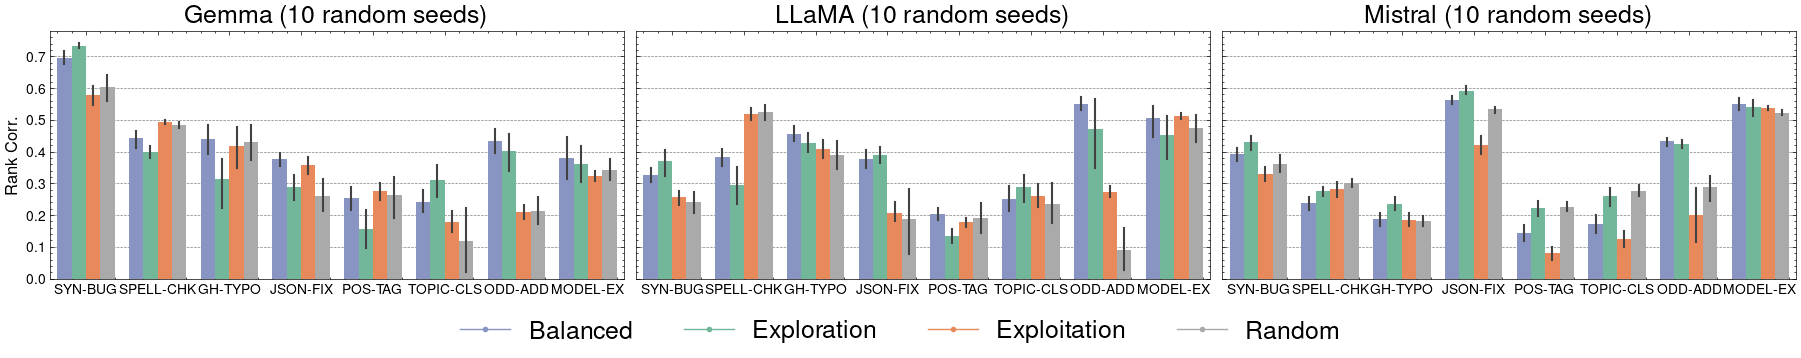

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import os

from matplotlib.lines import Line2D

plt.style.use(["science", "grid", "nature"])

hue_order = ["balanced", "diversity_euclidean", "entropy", "random"]

custom_colors = ["#8895C3", "#73B79B", "#E7895B", "#AAAAAA"]

task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

target_method_map = {
    'balanced': 'Balanced',
    'diversity_euclidean': 'Exploration',
    'entropy': 'Exploitation',
    'random': 'Random',
}

plt.rcParams.update({
    "font.size": 12,           
    "axes.titlesize": 14,      
    "axes.labelsize": 12,      
    "xtick.labelsize": 10,     
    "ytick.labelsize": 10,     
    "legend.fontsize": 10,     
})

num_reference = 500
model = 'llama'

fig, axes = plt.subplots(1, 3, figsize=(6 * 3, 3), constrained_layout=True, sharey=True)

target_df = df[(df.num_reference == num_reference)].copy()
target_df['Task ID'] = target_df.task.map(task_alias_map)
target_df['Rank Corr.'] = target_df.pearson_r

for i, model in enumerate(['Gemma', 'LLaMA', 'Mistral']):
    target_model_df = target_df[target_df.model.str.lower() == model.lower()]
    # grouped_df = target_model_df.groupby(['model', 'task', 'sampling_method']).mean()

    sns.barplot(data=target_model_df, x='Task ID', y='Rank Corr.', hue='sampling_method', ax=axes[i], hue_order=hue_order, palette=custom_colors, legend=False, saturation=1.0)
    axes[i].set_title(f'{model} (10 random seeds)', fontsize=18)
    axes[i].set_xlabel('')
    
handles = [
    Line2D([0], [0], marker='o', linestyle='-', label=lab, color=custom_colors[j])
    for j, lab in enumerate(hue_order)
]
fig.legend(handles=handles, labels=[target_method_map[lab] for lab in hue_order],
           loc='upper center', ncol=len(hue_order),
           frameon=False, bbox_to_anchor=(0.5, 0.01), fontsize=18)

os.makedirs('./figures/rq1_2', exist_ok=True)
fig.savefig('./figures/rq1_2/sampling_methods_comparison_n{}.png'.format(num_reference))
fig.savefig('./figures/rq1_2/sampling_methods_comparison_n{}.pdf'.format(num_reference))

In [10]:
summary = target_df.groupby(['task', 'model', 'sampling_method'])[['pearson_r']].mean().reset_index().pivot(index=['task', 'model'], columns='sampling_method', values='pearson_r')
display(summary)
print(summary.describe())

sampling_method                  balanced  diversity_euclidean   entropy  \
task                    model                                              
adding_odd_numbers      gemma    0.434297             0.403158  0.210573   
                        llama    0.551083             0.471631  0.273727   
                        mistral  0.431731             0.423230  0.200381   
github_typo_check       gemma    0.440370             0.312801  0.417356   
                        llama    0.456102             0.427334  0.407097   
                        mistral  0.188131             0.234811  0.185941   
json_repair             gemma    0.376916             0.287074  0.356227   
                        llama    0.377014             0.388154  0.208100   
                        mistral  0.562467             0.592066  0.420569   
model_name_extraction   gemma    0.379087             0.360834  0.324240   
                        llama    0.504898             0.451156  0.513184   
                        mistral  0.549805             0.540141  0.536080   
pos_detection           gemma    0.252316             0.156640  0.276940   
                        llama    0.203475             0.135331  0.177419   
                        mistral  0.143117             0.221635  0.080339   
spell_check             gemma    0.441210             0.398690  0.494000   
                        llama    0.384054             0.295496  0.518482   
                        mistral  0.237310             0.277098  0.281551   
syntactic_bug_detection gemma    0.695501             0.733470  0.576952   
                        llama    0.327738             0.371567  0.255986   
                        mistral  0.390980             0.429407  0.329567   
topic_classification    gemma    0.241658             0.310848  0.177716   
                        llama    0.251251             0.287247  0.259188   
                        mistral  0.170487             0.258531  0.126184   

sampling_method                    random  
task                    model              
adding_odd_numbers      gemma    0.211727  
                        llama    0.091564  
                        mistral  0.288863  
github_typo_check       gemma    0.429006  
                        llama    0.389679  
                        mistral  0.181490  
json_repair             gemma    0.261663  
                        llama    0.188056  
                        mistral  0.532435  
model_name_extraction   gemma    0.342860  
                        llama    0.475335  
                        mistral  0.522382  
pos_detection           gemma    0.262055  
                        llama    0.192339  
                        mistral  0.225596  
spell_check             gemma    0.484888  
                        llama    0.525563  
                        mistral  0.302216  
syntactic_bug_detection gemma    0.602248  
                        llama    0.242504  
                        mistral  0.362157  
topic_classification    gemma    0.119885  
                        llama    0.235145  
                        mistral  0.276902

sampling_method   balanced  diversity_euclidean    entropy     random
count            24.000000            24.000000  24.000000  24.000000
mean              0.374625             0.365348   0.316992   0.322773
std               0.142631             0.136212   0.140451   0.142500
min               0.143117             0.135331   0.080339   0.091564
25%               0.248853             0.284580   0.206171   0.222129
50%               0.381571             0.366200   0.279245   0.282883
75%               0.444933             0.427853   0.418159   0.440589
max               0.695501             0.733470   0.576952   0.602248


,pearson_r,roc_auc,num_reference,sampling_method,task,model,seed,n_components,n_features
0,0.254650,0.676280,10,balanced,spell_check,llama,0,5,5
1,0.254651,0.676280,10,balanced,spell_check,llama,1,5,5
2,0.303297,0.729687,10,balanced,spell_check,llama,2,5,5
3,0.339351,0.740877,10,balanced,spell_check,llama,3,5,5
4,0.254649,0.676278,10,balanced,spell_check,llama,4,5,5


100%|██████████| 8/8 [00:00<00:00, 19.66it/s]


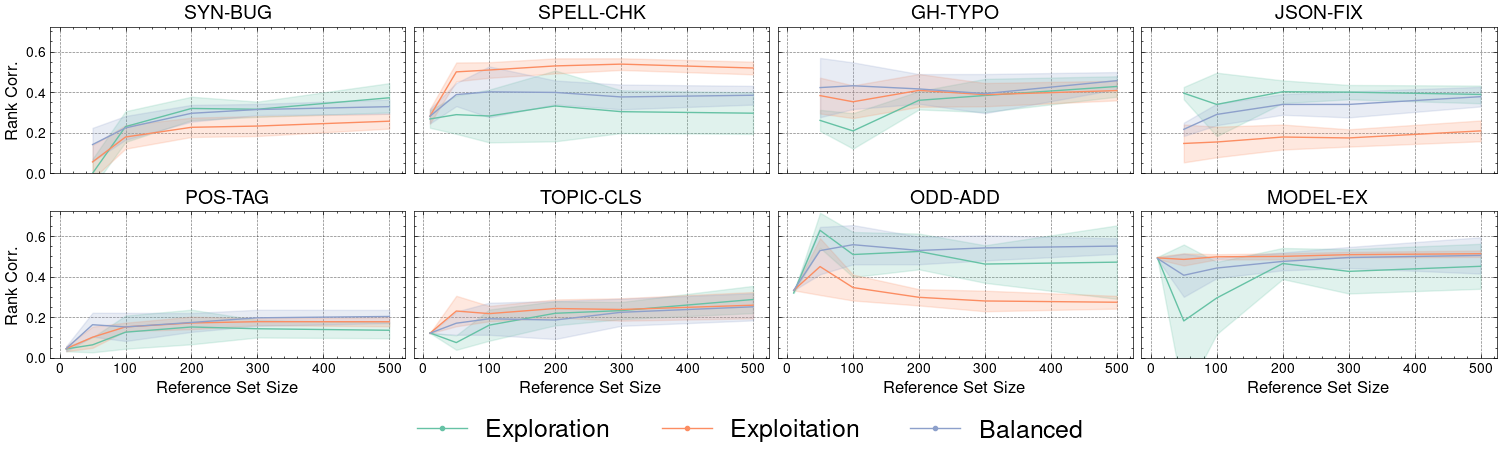

In [11]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 4, figsize=(15, 4), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

model = 'llama'
target_df = df[(df['model'] == model)].copy()
display(target_df.head())
ymax = target_df['pearson_r'].max()
target_df.loc[:, 'Rank Corr.'] = target_df.pearson_r
target_df.loc[:, 'Reference Set Size'] = target_df.num_reference

compare_targets = ['diversity_euclidean', 'entropy', 'balanced']
palette = sns.color_palette('Set2', n_colors=len(compare_targets))

for i, task in enumerate(tqdm(target_testsuites, position=0)):
    iteration_df = target_df[target_df.task == task]
    sns.lineplot(
        data=iteration_df[iteration_df.sampling_method.isin(compare_targets)],
        x='Reference Set Size',
        y='Rank Corr.',
        hue='sampling_method',
        hue_order=compare_targets,
        palette=palette,
        errorbar='sd',
        ax=axes[i],
        legend=False
    )
    axes[i].set_title(f'{task_alias_map[task]}')
    axes[i].set_ylim(bottom=0, top=ymax * 1.05)

handles = [
    Line2D([0], [0], marker='o', linestyle='-', label=lab, color=palette[j])
    for j, lab in enumerate(compare_targets)
]
fig.legend(handles=handles, labels=[target_method_map[lab] for lab in compare_targets],
           loc='upper center', ncol=len(compare_targets),
           frameon=False, bbox_to_anchor=(0.5, 0.01), fontsize=18)

fig.savefig('./figures/rq1_2/sampling_methods_iteration_{}.png'.format(model))
fig.savefig('./figures/rq1_2/sampling_methods_iteration_{}.pdf'.format(model))

4it [00:00,  5.84it/s]00:00<?, ?it/s]
4it [00:00,  7.95it/s]00:00<00:00,  1.20it/s]
100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


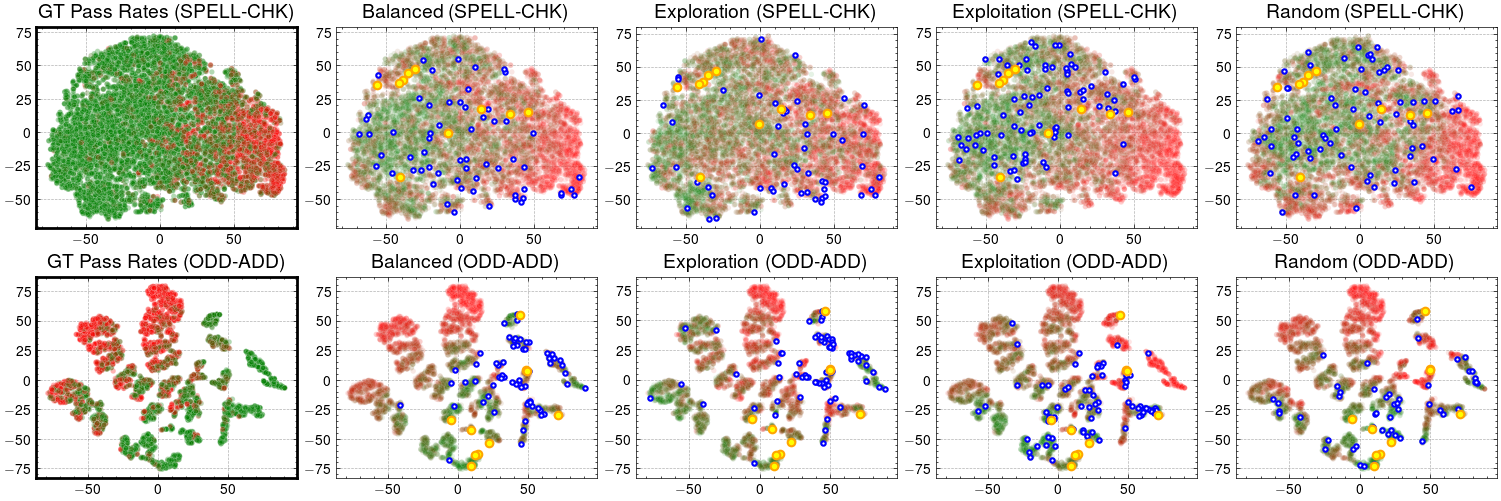

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)

def plot_reference_points(df_vis, title, ax=None, only_plot_passing_points=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    if only_plot_passing_points:
        _df_vis = df_vis[df_vis['test_score'] > 0.5]
    else:
        _df_vis = df_vis
    
    sns.scatterplot(data=df_vis, x='Component 1', y='Component 2', hue='logprob_rank', palette=cmap, alpha=0.1, s=15, ax=ax)
    sns.scatterplot(data=_df_vis[_df_vis.label == 'ref'], x='Component 1', y='Component 2', color='white', edgecolor='blue', alpha=1.0, s=10, linewidth=1.5, ax=ax)
    df_vis_initial = _df_vis[_df_vis.input_index >= len(df_vis) - 10]
    sns.scatterplot(data=df_vis_initial, x='Component 1', y='Component 2', color='yellow', edgecolor='orange', alpha=1.0, s=30, linewidth=1.5, ax=ax, label='Initial tests')

    ax.grid(alpha=0.3)
    ax.set_title(title)
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

seed = 0
vis_tasks = ['spell_check', 'adding_odd_numbers']
iteration = 10

fig, axes = plt.subplots(len(vis_tasks), len(target_method_map) + 1, figsize=(3 * (len(target_method_map) + 1), 2.5 * len(vis_tasks)), sharex=False, sharey=False, constrained_layout=True)

model = 'llama'
target_layer = target_layer_map[model]
seed = 0

result_suffix = f"_{model}"

for i, task in enumerate(tqdm(vis_tasks)):
    result_df_path = '../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, target_layer, 0, 'balanced')
    df_vis = pd.read_pickle(result_df_path)
    df_vis_target_iter = df_vis[df_vis['iteration'] == iteration]
    sns.scatterplot(data=df_vis_target_iter, x='Component 1', y='Component 2', hue='test_score', palette=cmap, alpha=0.3, s=15, ax=axes[i, 0])
    axes[i, 0].grid(alpha=0.3)
    axes[i, 0].set_title("GT Pass Rates ({})".format(task_alias_map[task]), fontweight='bold')
    axes[i, 0].legend([], [], frameon=False)
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')
    for spine in axes[i, 0].spines.values():
        spine.set_linewidth(2)
        spine.set_color("black")
    
    for _j, target_method in tqdm(enumerate(target_method_map)):
        j = _j + 1
        if target_method == 'entropy':
            _target_method = 'uncertainty'
        else:
            _target_method = target_method
        result_df_path = '../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, target_layer, seed, _target_method)
        df_vis = pd.read_pickle(result_df_path)
        df_vis_target_iter = df_vis[df_vis['iteration'] == iteration]

        plot_reference_points(df_vis_target_iter, title='{} ({})'.format(target_method_map[target_method], task_alias_map[task]), ax=axes[i, j])
    
fig.savefig('./figures/rq1_2/reference_points_{}_iter{}_seed{}_selected_tasks.png'.format(model, iteration, seed))
fig.savefig('./figures/rq1_2/reference_points_{}_iter{}_seed{}_selected_tasks.pdf'.format(model, iteration, seed))
